<a href="https://colab.research.google.com/github/aldebaro/ai6g/blob/main/solutions_01_detection_qam_over_awgn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Inteligência Artificial e Aprendizado de Máquina Aplicados a Redes 5G e 6G.
Aldebaro Klautau (UFPA). Minicurso 5 do SBrT - 25 de setembro de 2022.

# QAM classifiers

In [164]:
# Clone the repository if running in Colab and install all the dependencies
if 'google.colab' in str(get_ipython()):
    import sys
    import os
    try:
      !git clone https://github.com/aldebaro/ai6g.git
    except:
      print("ai6g is already in the contents")
    %cd ai6g
    !pip install -r requirements.txt

In [165]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from commpy.channels import SISOFlatChannel

from files_01_detection.qam_crazy import crazy_channel_propagate
from files_01_detection.qam_awgn import generate_symbols
from files_01_detection.qam_analyzer import plot_decision_boundary, theoretical_ser, ser, plot_confusion_matrix
#from files_01_detection.classifiers_comparison import train_classifier
 
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Classifiers for QAM demodulation

### Variables

In [166]:
channel_type = 'awgn' # 'awgn' or 'crazy'
M            = 16      # QAM modulation
total_num_symbols  = 12000    # Number of transmitted symbols to be used for training and test
train_fraction = 0.5 # Fraction of whole data to be used for training (the remaining is for testing)
SNR_dB       = 15      # Signal to noise ratio in dB     
code_rate    = 1       # Rate of the used code
Es           = 1       # Average symbol energy

In [167]:
#plot theoretical symbol error probability (SER) for this SNR
Pe = theoretical_ser(M, SNR_dB)
print("Theoretical symbol error probability (SER) =", 100.0*Pe, "% for SNR =", SNR_dB,"dB")

Theoretical symbol error probability (SER) = 1.7781842241805894 % for SNR = 15 dB


### Generate QAM symbols and transmit them over the channel

In [168]:
# Generate the QAM symbols
symbs, indices = generate_symbols(total_num_symbols, M)

In [169]:
if channel_type == 'awgn':
    channel = SISOFlatChannel(None, (1 + 0j, 0j))
    channel.set_SNR_dB(SNR_dB, float(code_rate), Es)
    channel_output = channel.propagate(symbs)
elif channel_type == 'crazy':
    channel_output = crazy_channel_propagate(symbs, SNR_dB) 
else:
    raise ValueError(f'Channel type {channel_type} not found')

In [170]:
# Generate dataset
# Train
train_size = int(train_fraction*total_num_symbols) #data used for training
y_train = indices[:train_size]
X_train = np.stack([np.real(channel_output[:train_size]),
                    np.imag(channel_output[:train_size])], axis=1)

# Test
y_test = indices[train_size:]
X_test = np.stack([np.real(channel_output[train_size:]),
                   np.imag(channel_output[train_size:])], axis=1)

In [171]:
def plot_symbols():
    custom_cmap = cm.get_cmap('tab20')
    num_classes = M
    colors = custom_cmap.colors[:num_classes]
    levels = np.arange(num_classes + 2) - 0.5

    for ii in range(num_classes):
        selected_indices = np.argwhere(y_train==ii)
        selected_indices = selected_indices.reshape((-1))
        plt.plot(X_train[selected_indices, 0], X_train[selected_indices, 1], 'o', color=colors[ii], label=f'{ii}')
        
    plt.plot(np.real(symbs), np.imag(symbs), 'rx')
    plt.legend(title='Classes', bbox_to_anchor=(1, 1), loc='upper left', ncol=2, handleheight=2, labelspacing=0.05, frameon=False)
    plt.ylabel('Quadrature')
    plt.xlabel('In-phase')

    plt.show()  

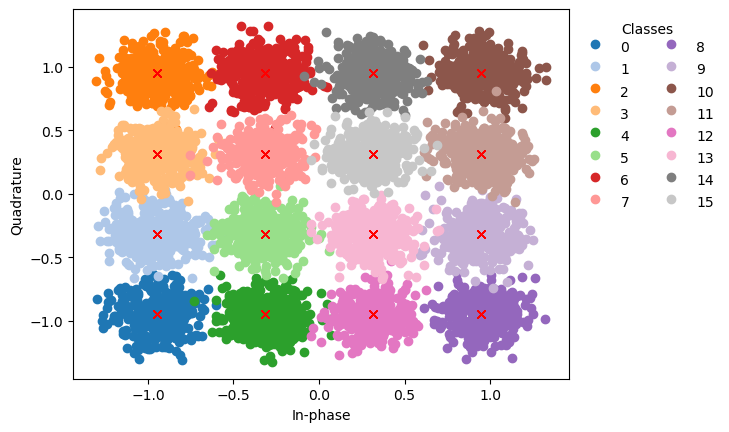

In [172]:
plot_symbols()

## Classifiers

In [173]:
def train_classifier(clf_name, X, y, num_classes):
    """
    Parameters
    ==========
    clf_name: str
        Classifier name to be selected
    X:
    y:
    num_classes: int
        Total number of classes

    """
    names = ["Naive Bayes",
             "Decision Tree", "Random Forest",
             "AdaBoost",
             "Linear SVM", "RBF SVM", "Gaussian Process",
             "Neural Net",
             "QDA", "Nearest Neighbors"]

    classifiers = [
        GaussianNB(),
        DecisionTreeClassifier(max_depth=100),
        RandomForestClassifier(max_depth=100, n_estimators=30),
        AdaBoostClassifier(),
        LinearSVC(), #linear SVM (maximum margin perceptron)
        SVC(gamma=1, C=1),
        GaussianProcessClassifier(1.0 * RBF(1.0)),
        MLPClassifier(alpha=0.1, max_iter=500),
        QuadraticDiscriminantAnalysis(),
        KNeighborsClassifier(3)]

    assert(clf_name in names)

    clf_ind = names.index(clf_name)
    clf = classifiers[clf_ind]
    clf.fit(X, y)

    return clf

### Decision Tree

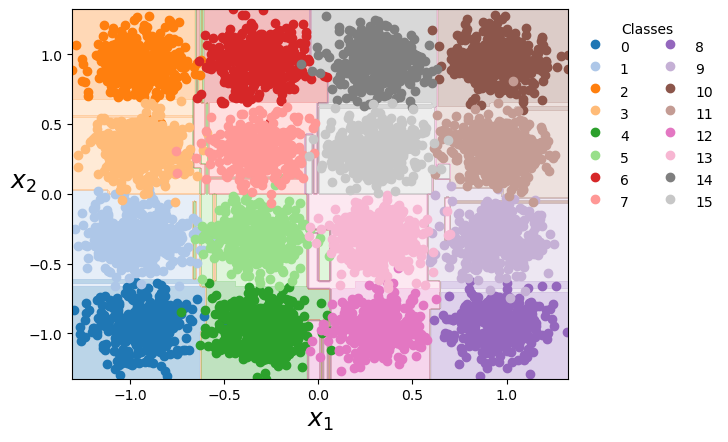

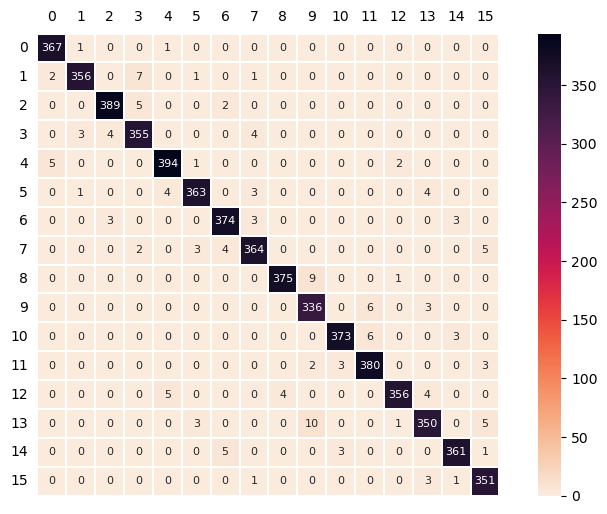

In [174]:
clf_DT = train_classifier('Decision Tree', X_train, y_train, M)
plot_decision_boundary(clf_DT, X_train, y_train, legend=True)
plot_confusion_matrix(clf_DT, X_test, y_test, M)

In [175]:
clf_DT_ser = ser(clf_DT, X_test, y_test)
print(f'Decision Tree:\n SER:\t {clf_DT_ser:.2%}')

Decision Tree:
 SER:	 2.60%


### Random Forest

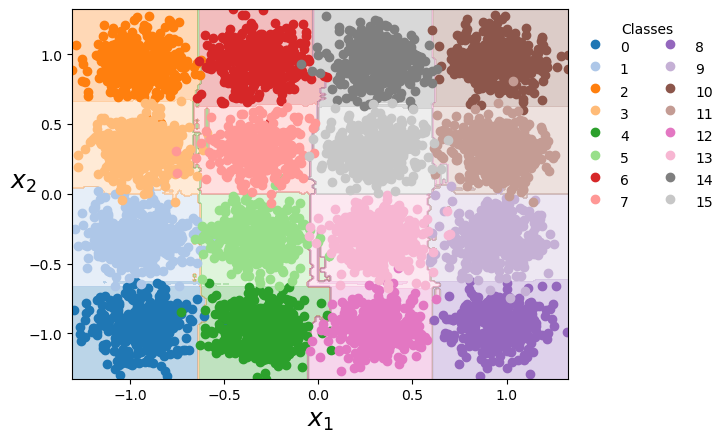

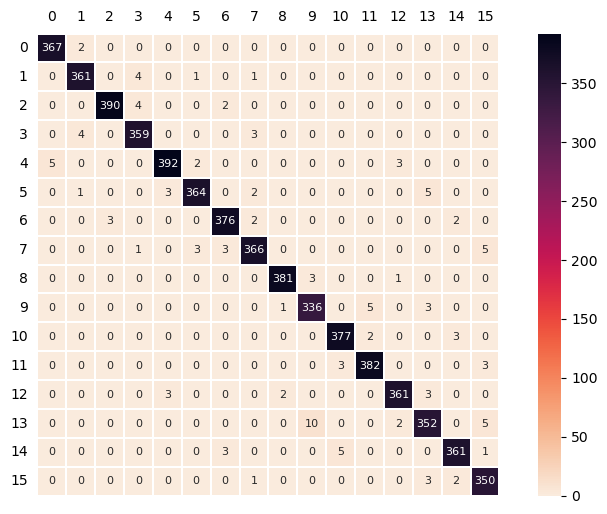

In [176]:
clf_RF = train_classifier('Random Forest', X_train, y_train, M)
plot_decision_boundary(clf_RF, X_train, y_train, legend=True)
plot_confusion_matrix(clf_RF, X_test, y_test, M)

In [177]:
clf_RF_ser = ser(clf_RF, X_test, y_test)
print(f'Random Forest:\n SER:\t {clf_RF_ser:.2%}')

Random Forest:
 SER:	 2.08%


### K-nearest neighbors

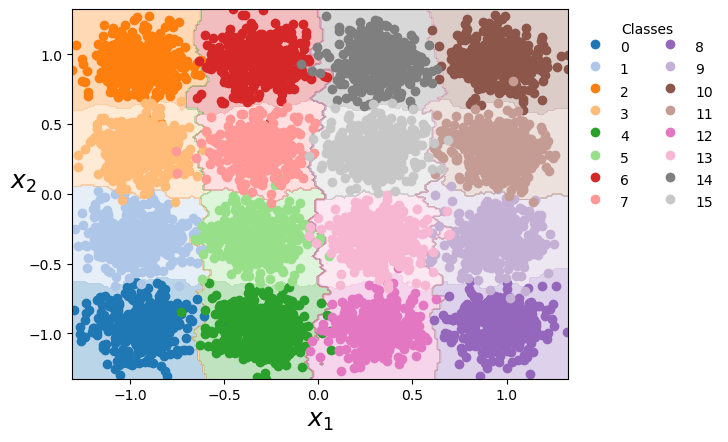

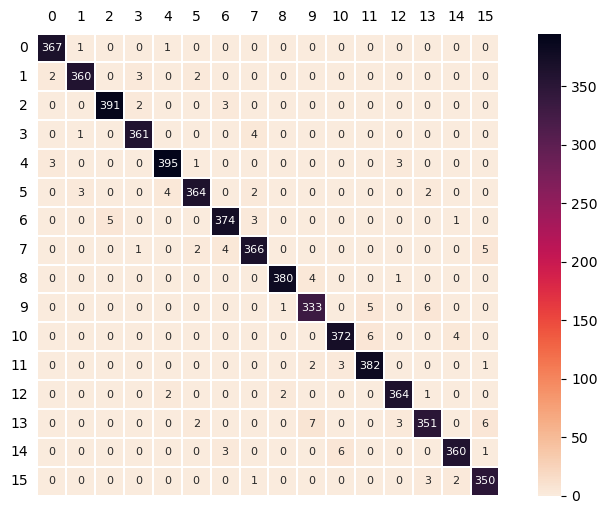

In [178]:
clf_KNN = train_classifier('Nearest Neighbors', X_train, y_train, M)
plot_decision_boundary(clf_KNN, X_train, y_train, legend=True)
plot_confusion_matrix(clf_KNN, X_test, y_test, M)

In [179]:
clf_KNN_ser = ser(clf_KNN, X_test, y_test)
print(f'K-nearest neighbors:\n SER:\t {clf_KNN_ser:.2%}')

K-nearest neighbors:
 SER:	 2.17%


### Linear SVM

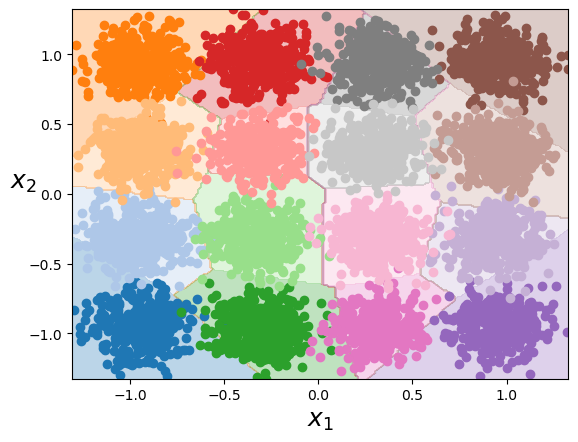

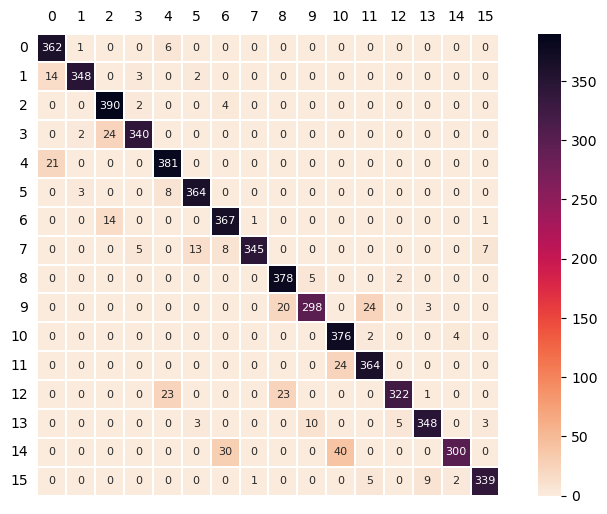

In [180]:
clf_LSVM = train_classifier('Linear SVM', X_train, y_train, M)
plot_decision_boundary(clf_LSVM, X_train, y_train)
plot_confusion_matrix(clf_LSVM, X_test, y_test, M)

In [181]:
clf_LSVM_ser = ser(clf_LSVM, X_test, y_test)
print(f'Linear SVM:\n SER:\t {clf_LSVM_ser:.2%}')

Linear SVM:
 SER:	 6.30%


### SVM with RBF Kernel

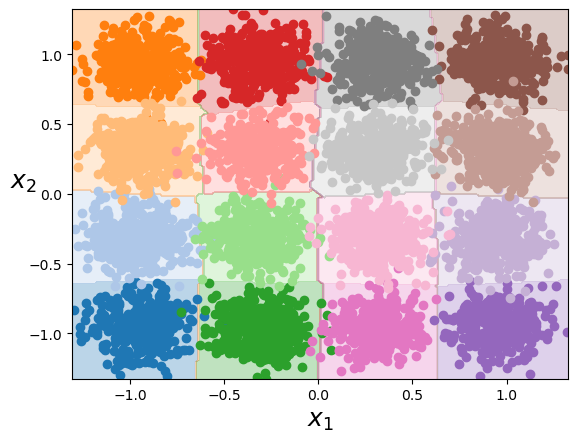

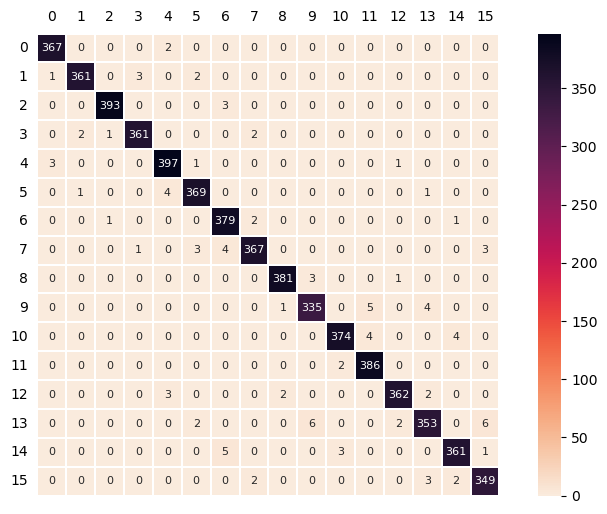

In [182]:
clf_LSVM_RBF = train_classifier('RBF SVM', X_train, y_train, M)
plot_decision_boundary(clf_LSVM_RBF, X_train, y_train)
plot_confusion_matrix(clf_LSVM_RBF, X_test, y_test, M)

In [183]:
clf_LSVM_RBF_ser = ser(clf_LSVM_RBF, X_test, y_test)
print(f'SVM with RBF kernel:\n SER:\t {clf_LSVM_RBF_ser:.2%}')

SVM with RBF kernel:
 SER:	 1.75%


### MLP

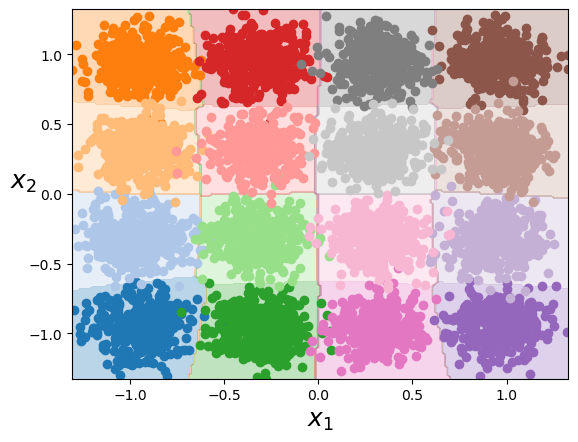

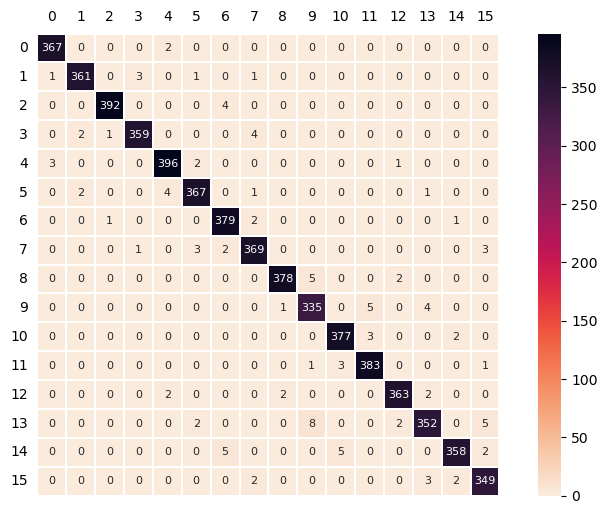

In [184]:
clf_MLP = train_classifier('Neural Net', X_train, y_train, M)
plot_decision_boundary(clf_MLP, X_train, y_train)
plot_confusion_matrix(clf_MLP, X_test, y_test, M)

In [185]:
clf_MLP_ser = ser(clf_MLP, X_test, y_test)
print(f'Neural network (MLP):\n SER:\t {clf_MLP_ser:.2%}')

Neural network (MLP):
 SER:	 1.92%


### Naive Bayes

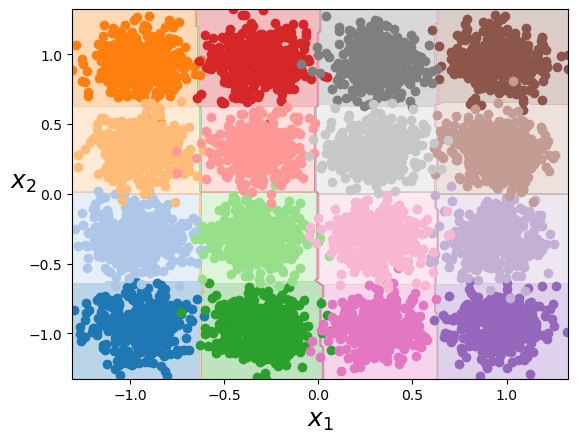

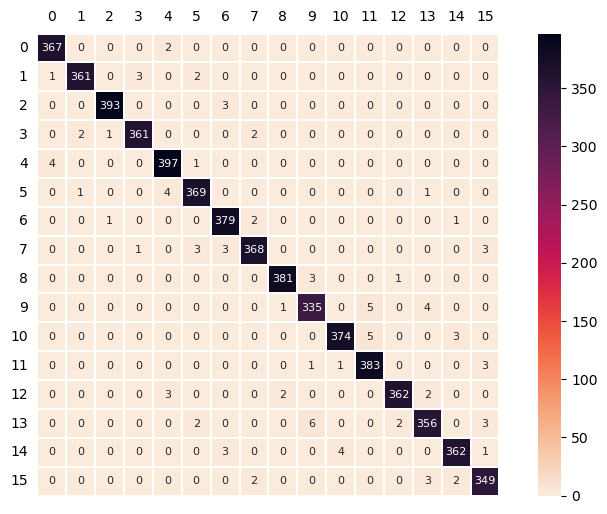

In [186]:
clf_NB = train_classifier('Naive Bayes', X_train, y_train, M)
plot_decision_boundary(clf_NB, X_train, y_train)
plot_confusion_matrix(clf_NB, X_test, y_test, M)

In [187]:
clf_NB_ser = ser(clf_MLP, X_test, y_test)
print(f'Naive Bayes:\n SER:\t {clf_NB_ser:.2%}')

Naive Bayes:
 SER:	 1.92%


## Authors

- [Douglas Maia dos Santos - LASSE/UFPA](https://github.com/m-dougl)
- [José de Deus e Silva Neto - LASSE/UFPA](https://github.com/NectxX)